# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

%matplotlib inline  


df = pd.read_csv('human_body_temperature.csv')

### 1. Is the distribution of body temperatures normal?

In [2]:
summary_stats=df.temperature.describe()

In [3]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  
/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


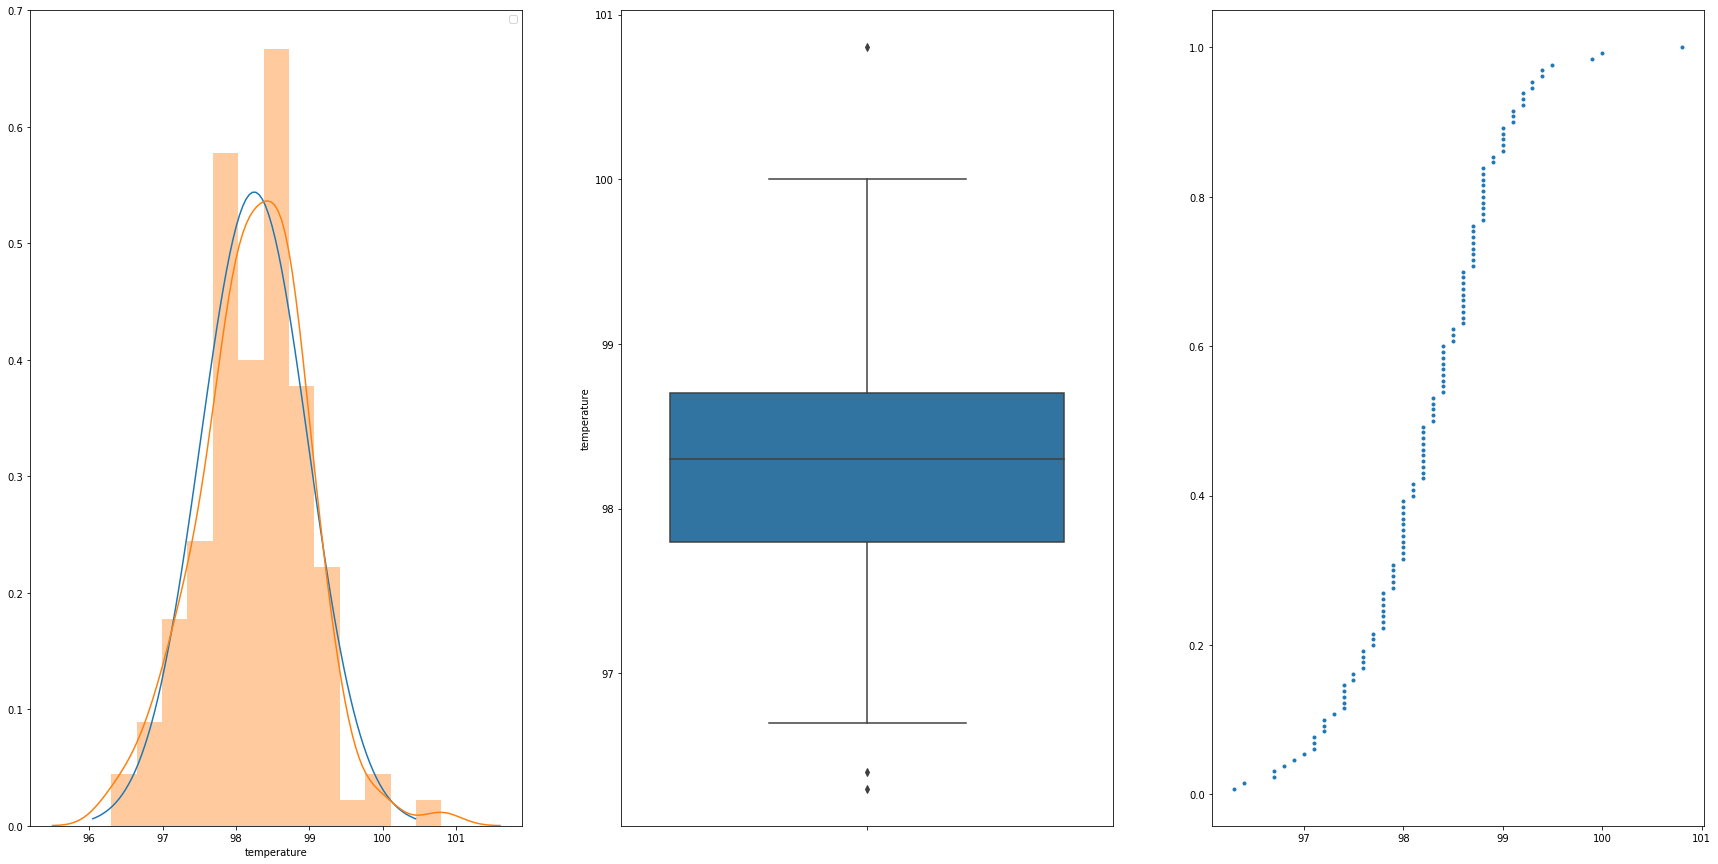

In [4]:
#draw subplot with boxplot, ECDF
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,15))

mean = summary_stats['mean']
std = summary_stats['std']
x = np.linspace(mean - 3*std, mean + 3*std, 100)

ax1.plot(x,mlab.normpdf(x, mean, std))
sns.distplot(df.temperature, ax=ax1)
ax1.legend(loc='upper right')

ax2=sns.boxplot(y='temperature', data=df, ax=ax2)

temp_x,temp_y=ecdf(df['temperature'])
ax3.plot(temp_x, temp_y, marker='.', linestyle='none')

In [5]:
def calculate_z(value, mean, std):
    z_score= (value-mean) / std
    return z_score

z_max= calculate_z(summary_stats['max'], summary_stats['mean'], summary_stats['std'])
z_min= calculate_z(summary_stats['min'], summary_stats['mean'], summary_stats['std'])

print('Z-score for maximum value is ', z_max, ' Z-score for minimum value is ', z_min)

Z-score for maximum value is  3.479034130559948  Z-score for minimum value is  -2.6585863953072972


In [6]:
statistic, p=stats.normaltest(df.temperature)

In [7]:
alpha = 1e-3 #0.05
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

The null hypothesis cannot be rejected


### 2. Is the sample size large? Are the observations independent?

sample size > 30
and independence <10% of total population

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


### 3. Is the true population mean really 98.6 degrees F?
 <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>

In [9]:
sample_temps=np.array(df.temperature)

In [10]:
new_temps=sample_temps-np.mean(sample_temps)+98.6

In [11]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates

In [12]:
def difference_from_original(data, original=98.6):
    return (np.mean(data)-original)

diff_observed=difference_from_original(sample_temps)
print(diff_observed)

-0.35076923076924515


In [13]:
bs_reps = draw_bs_reps(new_temps, difference_from_original, 100000)

In [14]:
p_val=np.sum(bs_reps<=diff_observed) /len(bs_reps)
p_val

0.0

Hypothesis testing: H0 -> u=98.6
Ha -> u!=98.6

one sample 2-tailed t-test

In [15]:
sample_mean= summary_stats['mean']
sample_std= summary_stats['std']
sample_size= df.temperature.count()
hypothesis_value=98.6

In [16]:
def t_score_p_value(mean,std,n,value):
    t=(mean-value)/(std/(n**0.5))
    pval = stats.t.sf(np.abs(t), n-1)*2
    return t,pval

In [17]:
t_value,p_value=t_score_p_value(sample_mean, sample_std, sample_size, hypothesis_value)

In [18]:
p_value

2.4106320415609943e-07

### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

In [19]:
draw_10=df['temperature'].sample(10).values

In [20]:
draw_10_shifted=draw_10-np.mean(draw_10)+98.6

In [21]:
draw_10_diff=difference_from_original(draw_10)
print(draw_10_diff)

-0.3499999999999943


In [22]:
draw_10_bs_reps = draw_bs_reps(draw_10_shifted, difference_from_original, 100000)

p_val=np.sum(draw_10_bs_reps<=draw_10_diff) /len(draw_10_bs_reps)
p_val

0.0657

In [23]:
draw_10_mean= np.mean(draw_10)
draw_10_std= np.std(draw_10)
hypothesis_value=98.6

t_value,p_value=t_score_p_value(draw_10_mean, draw_10_std, 10, hypothesis_value)
p_value

0.15721687366321194

### 5. At what temperature should we consider someone's temperature to be "abnormal"?

In [26]:
np.percentile(sample_temps, [2.5,97.5])

array([96.7225, 99.4775])

In [27]:
bs_reps_mean = draw_bs_reps(sample_temps, np.mean, 100000)

np.percentile(bs_reps_mean, [2.5,97.5])

array([98.12384615, 98.37615385])

### 6. Is there a significant difference between males and females in normal temperature?

2 sample t test

In [28]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [34]:
males=df[df.gender=='M']['temperature'].values
females=df[df.gender=='F']['temperature'].values

equal_var : bool, optional
If True (default), perform a standard independent 2 sample test that assumes equal population variances [1]. If False, perform Welch’s t-test, which does not assume equal population variance [2].

In [38]:
t, p = ttest_ind(males, females, equal_var=False)

In [39]:
p

0.023938264182934196